# Create Synthetic Dataset Using Faker and More

In [23]:
import pandas as pd
import numpy as np
from faker import Faker
from datetime import datetime, timedelta
import random
from scipy.stats import powerlaw

In [25]:
food_df=pd.read_csv('./dataset/dataset_gabungan_clean.csv')
user_df=pd.read_csv('./dataset/user_profile_height_weight.csv')

In [22]:
# Fungsi untuk mengubah tag rasa menjadi list
def parse_taste_tags(tag_str):
    if pd.isna(tag_str):
        return []
    return [tag.strip() for tag in tag_str.split(',')]

# Tambahkan kolom list preferensi rasa
food_df['taste_tags'] = food_df['Tags (manis, gurih, asin, pedas, pahit)'].apply(parse_taste_tags)

# Buat mapping dari `food_id` ke preferensi rasa
food_taste_mapping = dict(zip(food_df['Nama'], food_df['taste_tags']))

# Tampilkan beberapa baris untuk verifikasi
print(list(food_taste_mapping.items())[:5])


[('lappet', ['manis', 'gurih']), ('kue adee meureudu', ['manis', 'gurih']), ('kelicuk', ['manis', 'gurih']), ('gonjeng', ['asin', 'manis', 'gurih']), ('buah hongas', ['asin', 'manis'])]


## User-Item Interaction Dataset

In [74]:
# Inisialisasi Faker
fake = Faker()

# Parameter untuk data sintetis
num_users = len(user_df)          # 320 pengguna
num_foods = len(food_df)          # 284 kuliner
num_interactions = 7000           # Jumlah interaksi yang diinginkan

# Daftar pengguna
user_ids = user_df['username'].tolist()

# Daftar kuliner
food_ids = food_df['Nama'].tolist()

# Buat mapping preferensi rasa pengguna
taste_options = ['manis', 'gurih', 'asin', 'pedas', 'pahit']
user_preferences = {user: random.sample(taste_options, k=random.randint(1, 3)) for user in user_ids}

# Distribusi interaksi per pengguna (power-law)
a = 1.5  # Parameter shape untuk power-law
sizes = powerlaw.rvs(a, size=num_users)
interactions_per_user = np.round(sizes / sizes.sum() * num_interactions).astype(int)

# Normalisasi agar total interaksi mendekati num_interactions
interactions_per_user = interactions_per_user * num_interactions // interactions_per_user.sum()

# Buat mapping popularitas kuliner (lebih populer, lebih sering dipilih)
popularity = np.random.dirichlet(np.ones(num_foods), size=1)[0]
food_popularity = dict(zip(food_ids, popularity))

# Fungsi untuk memilih food_id berdasarkan popularitas
def choose_food():
    foods = list(food_popularity.keys())
    probabilities = list(food_popularity.values())
    return np.random.choice(foods, p=probabilities)

# Definisikan distribusi rating yang diinginkan
# Definisikan distribusi rating dengan setengah poin
rating_choices = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
rating_probabilities = [0.02, 0.03, 0.05, 0.07, 0.11, 0.10, 0.17, 0.20, 0.25]  # Total = 1.00


# Fungsi untuk memilih food_id berdasarkan preferensi rasa pengguna
def choose_food_based_on_preference(user_id):
    user_pref = user_preferences[user_id]
    # Pilih food_id yang memiliki setidaknya satu preferensi rasa yang sesuai
    eligible_foods = [food for food in food_ids if set(user_pref).intersection(set(food_taste_mapping.get(food, [])))]
    if not eligible_foods:
        return choose_food()  # Jika tidak ada yang cocok, pilih berdasarkan popularitas
    return np.random.choice(eligible_foods)

# Membuat interaksi
interactions = []
interaction_counts = {}
max_interactions_per_user_item = 12

for user, count in zip(user_ids, interactions_per_user):
    for _ in range(count):
        food = choose_food_based_on_preference(user)
        
        # Cek jumlah interaksi sebelumnya
        key = (user, food)
        if interaction_counts.get(key, 0) >= max_interactions_per_user_item:
            continue  # Lewati jika sudah mencapai batas
        
        interaction_type = random.choices(
            ['purchase', 'click', 'add_to_wishlist', 'rating'],
            weights=[0.33, 0.34, 0.05, 0.28],
            k=1
        )[0]
        
        # Pilih rating berdasarkan distribusi yang diinginkan
        rating = np.random.choice(rating_choices, p=rating_probabilities) if interaction_type == 'rating' else None
        
        # Buat timestamp acak dalam 1 tahun terakhir
        random_days = random.randint(0, 365)
        random_seconds = random.randint(0, 86400)
        timestamp = datetime.now() - timedelta(days=random_days, seconds=random_seconds)
        
        interactions.append({
            'user_id': user,
            'food_id': food,
            'interaction_type': interaction_type,
            'timestamp': timestamp.strftime('%Y-%m-%d %H:%M:%S'),
            'rating': rating
        })
        
        # Update jumlah interaksi
        interaction_counts[key] = interaction_counts.get(key, 0) + 1

In [75]:
# Buat DataFrame interaksi
interaction_df = pd.DataFrame(interactions)
interaction_df.info()
# Verifikasi jumlah interaksi
print(f"Jumlah Interaksi yang Dibuat: {len(interaction_df)}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6689 entries, 0 to 6688
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           6689 non-null   object 
 1   food_id           6689 non-null   object 
 2   interaction_type  6689 non-null   object 
 3   timestamp         6689 non-null   object 
 4   rating            1921 non-null   float64
dtypes: float64(1), object(4)
memory usage: 261.4+ KB
Jumlah Interaksi yang Dibuat: 6689


In [80]:
#save to csv
interaction_df.to_csv('./dataset/interactions.csv', index=False)

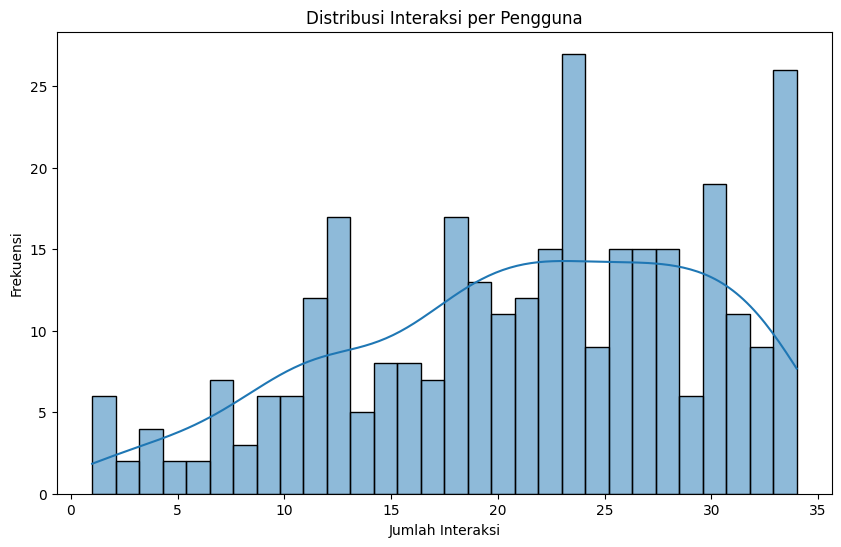

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribusi interaksi per pengguna
plt.figure(figsize=(10, 6))
sns.histplot(interaction_df['user_id'].value_counts(), bins=30, kde=True)
plt.title('Distribusi Interaksi per Pengguna')
plt.xlabel('Jumlah Interaksi')
plt.ylabel('Frekuensi')
plt.show()


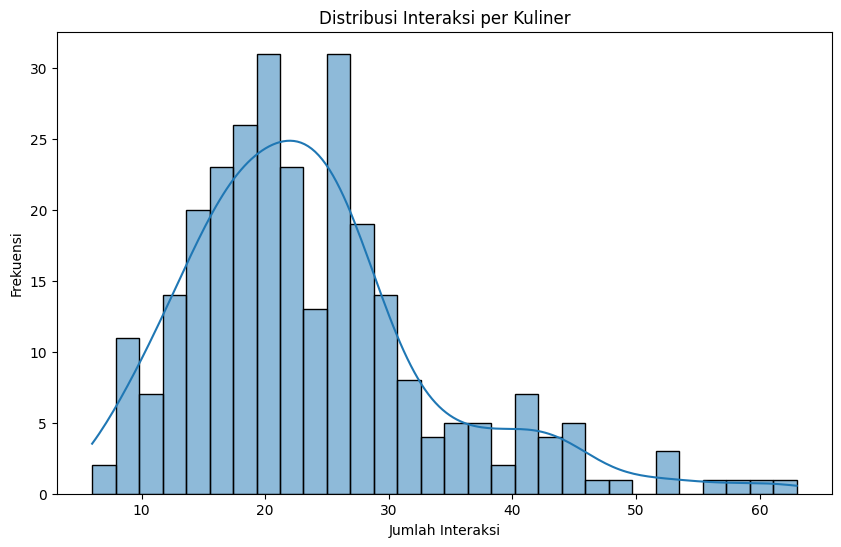

In [77]:
# Distribusi interaksi per kuliner
plt.figure(figsize=(10, 6))
sns.histplot(interaction_df['food_id'].value_counts(), bins=30, kde=True)
plt.title('Distribusi Interaksi per Kuliner')
plt.xlabel('Jumlah Interaksi')
plt.ylabel('Frekuensi')
plt.show()


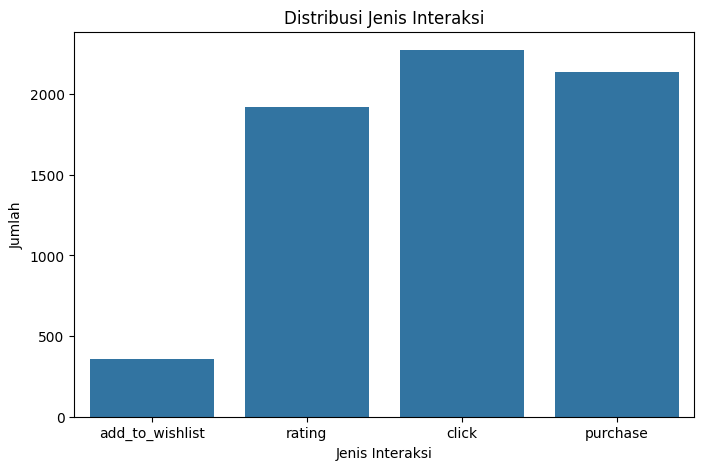

In [78]:
# Distribusi jenis interaksi
plt.figure(figsize=(8, 5))
sns.countplot(data=interaction_df, x='interaction_type')
plt.title('Distribusi Jenis Interaksi')
plt.xlabel('Jenis Interaksi')
plt.ylabel('Jumlah')
plt.show()


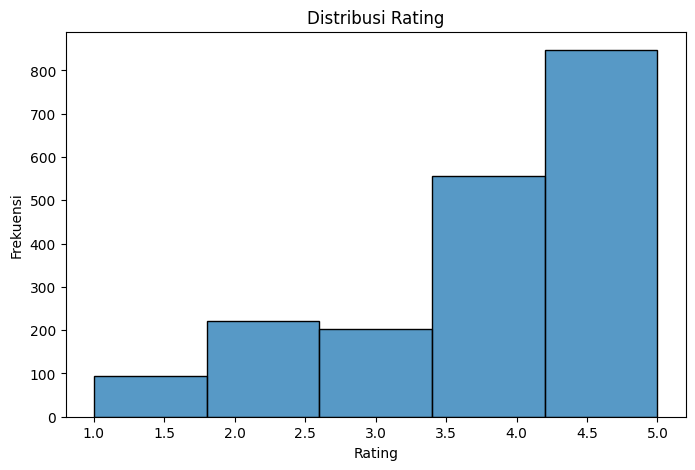

In [79]:
# Distribusi rating
plt.figure(figsize=(8, 5))
sns.histplot(interaction_df['rating'].dropna(), bins=5, kde=False)
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()


## Restaurant Dataset

In [83]:
# Inisialisasi Faker
fake = Faker()

# Parameter
num_restaurants = 62  # Jumlah restoran/UMKM yang diinginkan

# Daftar restoran
restaurant_ids = [f'restaurant_{i:04d}' for i in range(1, num_restaurants + 1)]

restaurants = []
for rest_id in restaurant_ids:
    name = fake.company()
    address = fake.address().replace('\n', ', ')
    # Misalkan setiap restoran menjual 5-15 kuliner
    num_foods_sold = random.randint(4, 10)
    sold_foods = random.sample(food_ids, num_foods_sold)
    
    restaurants.append({
        'restaurant_id': rest_id,
        'name': name,
        'address': address,
        'foods_sold': sold_foods
    })

# Buat DataFrame restoran
restaurants_df = pd.DataFrame(restaurants)

# Tampilkan beberapa baris
print("\nContoh Data Restoran:")
print(restaurants_df.head())



Contoh Data Restoran:
     restaurant_id                      name  \
0  restaurant_0001  Irwin, Hayden and Walker   
1  restaurant_0002            Nguyen-Stevens   
2  restaurant_0003             Alexander Inc   
3  restaurant_0004                 Jones Ltd   
4  restaurant_0005               Hood-Sawyer   

                                             address  \
0  3800 Williams Circles Apt. 729, Lake Jessicabe...   
1      9200 Turner Streets, Anthonyborough, ID 39694   
2          73921 Joshua Village, Tammyberg, DE 26428   
3  00037 Katherine Camp Suite 540, Veronicafurt, ...   
4       5547 Sandra Squares, Lake Samantha, UT 25433   

                                          foods_sold  
0           [sarabba, kue bangkit, kolo, ayam iloni]  
1  [kue lepek binti, kopi robusta lampung, kue om...  
2  [kue serabi solo, kue mayang papan, nasi gromb...  
3  [cacapan asam, roti srikaya, ce huan tiau, kop...  
4                       [tekwan, jepa, baram, lupis]  


In [ ]:
# Normalisasi Data (One Row per Restoran-Kuliner)
normalized_restaurants = restaurants_df.explode('foods_sold').rename(columns={'foods_sold': 'food_id'})
print("\nContoh Data Restoran yang Dinormalisasi:")
print(normalized_restaurants.head())



Contoh Data Restoran yang Dinormalisasi:
     restaurant_id                      name  \
0  restaurant_0001  Irwin, Hayden and Walker   
0  restaurant_0001  Irwin, Hayden and Walker   
0  restaurant_0001  Irwin, Hayden and Walker   
0  restaurant_0001  Irwin, Hayden and Walker   
1  restaurant_0002            Nguyen-Stevens   

                                             address          food_id  
0  3800 Williams Circles Apt. 729, Lake Jessicabe...          sarabba  
0  3800 Williams Circles Apt. 729, Lake Jessicabe...      kue bangkit  
0  3800 Williams Circles Apt. 729, Lake Jessicabe...             kolo  
0  3800 Williams Circles Apt. 729, Lake Jessicabe...       ayam iloni  
1      9200 Turner Streets, Anthonyborough, ID 39694  kue lepek binti  


In [85]:
# Simpan ke CSV
normalized_restaurants.to_csv('./dataset/restaurant.csv', index=False)
